In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
import warnings
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 9, 6

C:\Users\liuji\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [3]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Load Data

In [40]:
airPassen_df = pd.read_csv("./AirPassengers.csv", header = 0, parse_dates = [0], index_col = 0)

In [41]:
airPassen_df.sort_index(inplace=True)

In [42]:
airPassen_df.head()

,NoPassengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


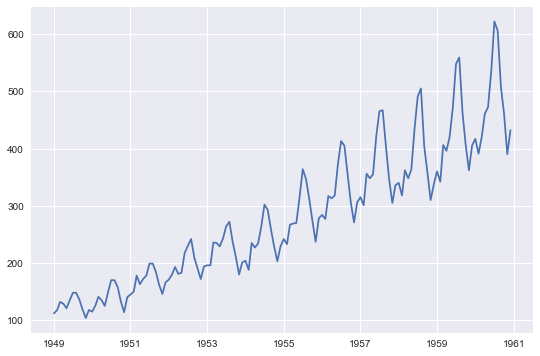

In [43]:
plt.plot(airPassen_df)

In [45]:
ts_airPassen = airPassen_df['NoPassengers']
ts_airPassen[:5]

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: NoPassengers, dtype: int64

### Test Stationarity

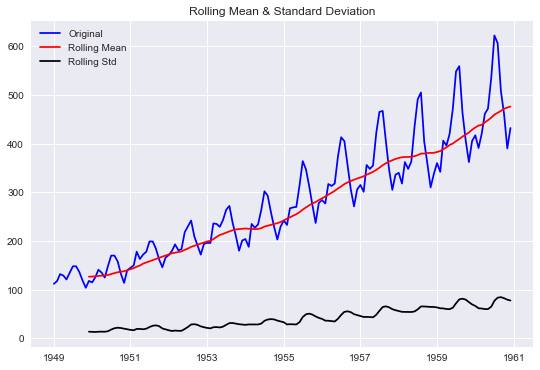

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [46]:
test_stationarity(ts_airPassen)

Rolling mean is greater than zero. Test Statistic is greater than Critical Value. So the time series is not stationary.

### Make Stationary

##### Take Log

In [48]:
ts_airPassen_log = np.log(ts_airPassen)

##### Differencing

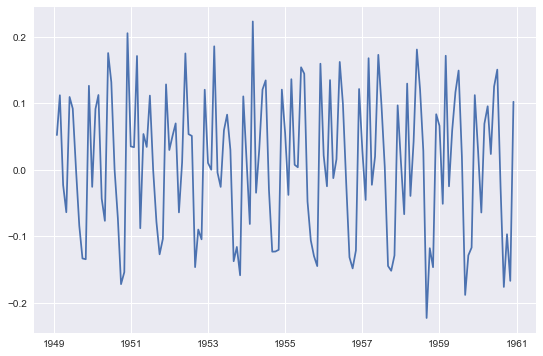

In [49]:
ts_airPassen_log_diff = ts_airPassen_log - ts_airPassen_log.shift()
plt.plot(ts_airPassen_log_diff)

In [50]:
ts_airPassen_log_diff.dropna(inplace = True)

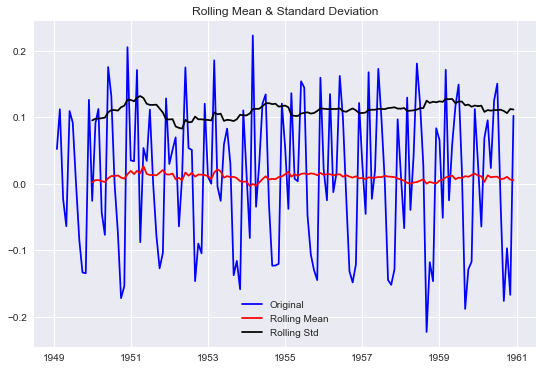

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [51]:
test_stationarity(ts_airPassen_log_diff)

Test Statistic is less than 10% Critical Value, which means the TS is stationary with 90% confidence.

##### Decomposing

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

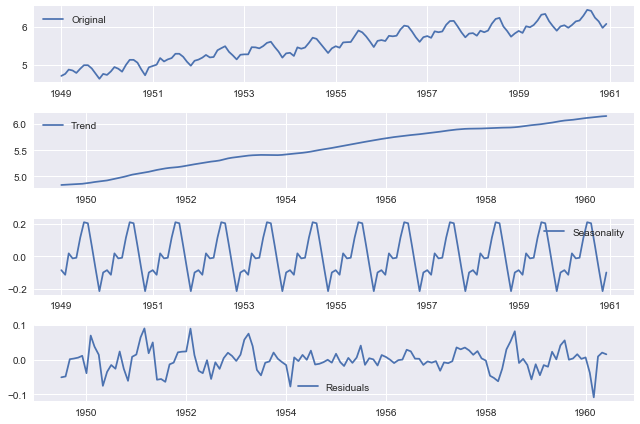

In [52]:
decomposition = seasonal_decompose(ts_airPassen_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_airPassen_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

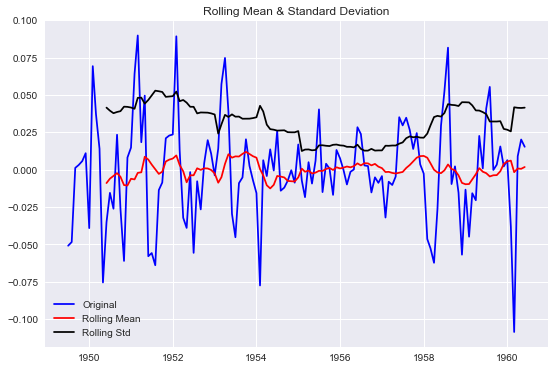

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [53]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

Test Statistic is less than 1% Critical Value, which means the TS is stationary with 99% confidence.

### ACF and PACF

In [19]:
from statsmodels.tsa.stattools import acf, pacf

Use Differencing for an example

In [54]:
lag_acf = acf(ts_airPassen_log_diff, nlags=20)
lag_pacf = pacf(ts_airPassen_log_diff, nlags=20, method='ols')

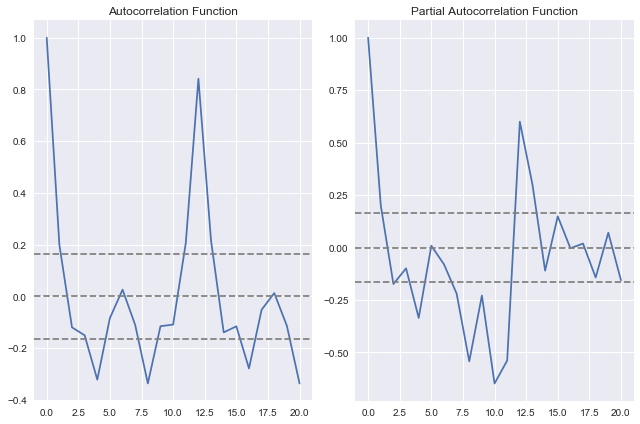

In [55]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_airPassen_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_airPassen_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_airPassen_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_airPassen_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

So p is 2 and q is 2.

### ARIMA Tuning

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

##### Determine Parameters

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_unemployment_rate_log.values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

##### Use predict method

In [56]:
X = ts_airPassen_log.values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# model = ARIMA(history, order=(4,1,2), seasonal_order=(1,1,1,12))
model = sm.tsa.statespace.SARIMAX(history, order=(4, 1, 2), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit(disp=-1)
predictions = model_fit.predict(size, len(X)-1)
print(predictions)

error = mean_squared_error(test, predictions)
print('Test MSE: %.8f' %error)
print('AIC: {0}'.format(model_fit.aic))

[ 5.86107986  5.82790837  5.98290119  5.96500233  5.97392786  6.12460052
  6.22964533  6.22083423  6.09271246  5.95432019  5.82791726  5.94332876
  5.97686701  5.94480862  6.09704631  6.07891578  6.09022747  6.23911251
  6.34240728  6.33348406  6.20669703  6.06993315  5.94466358  6.05881609
  6.0919868   6.06029149  6.21121989  6.19324672  6.20440653  6.35192125
  6.45429596  6.44547167  6.31983525  6.18430432  6.06017159  6.17329041]
Test MSE: 0.00614271
AIC: -357.3549629439953


##### Take log back

Test MSE: 276.15178064


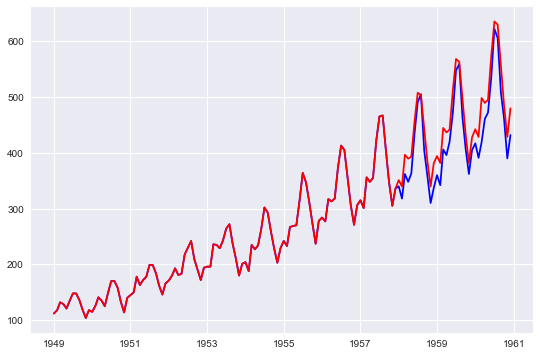

In [57]:
train_plus_prediction = np.concatenate((train, predictions))

predictions_ARIMA_log = pd.Series(train_plus_prediction, index=ts_airPassen_log.index)

predictions_ARIMA = np.exp(predictions_ARIMA_log)

error = mean_squared_error(ts_airPassen, predictions_ARIMA)
print('Test MSE: %.8f' %error)

plt.plot(ts_airPassen, color='blue')
plt.plot(predictions_ARIMA, color='red')
plt.show()